In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import statsmodels.api as sm
from statsmodels.formula.api import ols

sns.set_style("whitegrid")

## Data Import

In [2]:
test_scores = pd.read_csv('../data/test_scores.csv', index_col='State')

# Collections of columns of similar category for easy reference throughout 
sat_cols = test_scores.columns[test_scores.columns.str.contains('sat') &
                              ~test_scores.columns.str.contains('part') ]
sat_st_cols = sat_cols[sat_cols.str.contains('erw') | 
                       sat_cols.str.contains('math')]
act_cols = test_scores.columns[test_scores.columns.str.contains('act') &
                              ~test_scores.columns.str.contains('part') ]
act_st_cols = act_cols[act_cols.str.len() > 8]
part_cols = test_scores.columns[test_scores.columns.str.contains('part')]

## SAT and ACT Scores Correlate Negatively

Below we observe correlations opposite of what we observe at the individual level. High-performing students tend to score highly on both the SAT and ACT and across all subsections. Given a true random sample of students, we would expect to find a positive correlation between test scores and to see a similar distributions of SAT and ACT scores on their respective scales. Instead, we observe a negative correlation between state averages across SAT and ACT, including on comparable subjects wthin each.

The critical lurking variable here is participation rate. Because states have radically different participation rates between the two standardized tests, the body of students taking each differ dramatically. Whereas states with near universal participation rates on one test get an average representative of the larger student body, states with extremely small participation rates have average scores reflective of only the most high-performing students in that state. The tendency of states to mandate or incentivise one specific tests leads only students applying to the most selective university to particpate in the other, hence a -0.85 (-0.84) correlation coefficient for participation rates and the respective state average for the SAT (ACT) in 2018.

''

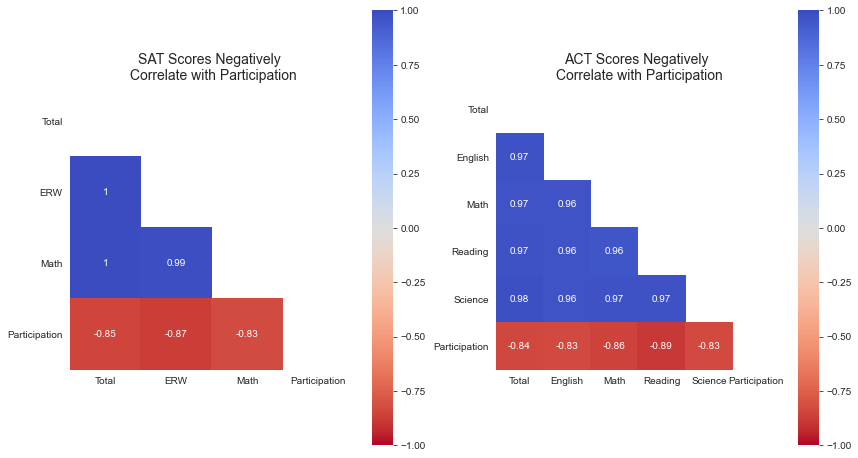

In [3]:
corr_sat_18 = test_scores.loc[:,test_scores.columns.str.contains('2018') & 
                           test_scores.columns.str.contains('sat')].corr()
corr_act_18 = test_scores.loc[:,test_scores.columns.str.contains('2018') & 
                           test_scores.columns.str.contains('act')].corr()

plt.figure(figsize=(14,8))
plt.subplot(1,2,1)
mask = np.zeros_like(corr_sat_18)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_sat_18, vmax=1, vmin=-1, mask=mask, square=True, annot=True, cmap='coolwarm_r', robust=True)
plt.title('SAT Scores Negatively \n Correlate with Participation', fontsize=14)
plt.yticks(rotation=0, ticks = [0.5,1.5,2.5,3.5], labels=['Total','ERW','Math','Participation'])
plt.xticks(rotation=0, ticks = [0.5,1.5,2.5,3.5], labels=['Total','ERW','Math','Participation'])

plt.subplot(1,2,2)
mask = np.zeros_like(corr_act_18)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_act_18, vmax=1, vmin=-1, mask=mask, square=True, annot=True, cmap='coolwarm_r', robust=True)
plt.title('ACT Scores Negatively \n Correlate with Participation', fontsize=14)
plt.yticks(rotation=0, ticks = [0.5,1.5,2.5,3.5,4.5, 5.5], 
           labels=['Total','English','Math','Reading','Science','Participation'])
plt.xticks(rotation=0, ticks = [0.5,1.5,2.5,3.5,4.5, 5.5], 
           labels=['Total','English','Math','Reading','Science','Participation'])
;

''

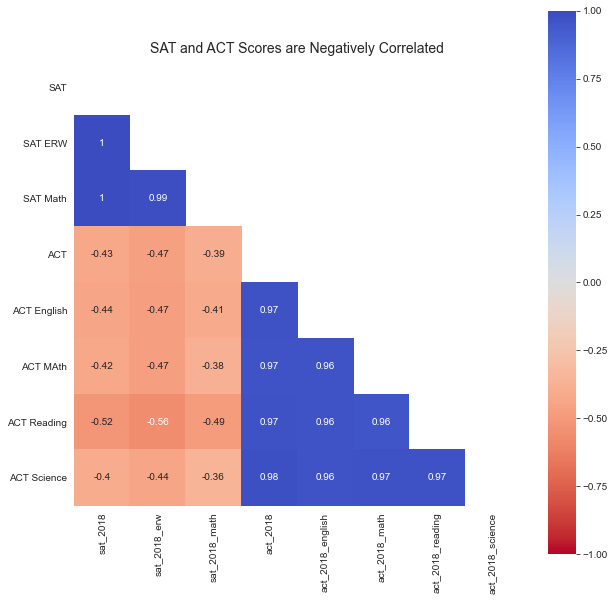

In [4]:
corr_2018 = test_scores.loc[:,test_scores.columns.str.contains('2018') &
                           ~test_scores.columns.str.contains('part')].corr()

plt.figure(figsize=(10,10))
mask = np.zeros_like(corr_2018)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr_2018, vmax=1, vmin=-1, mask=mask, square=True, annot=True, cmap='coolwarm_r', robust=True)
plt.title('SAT and ACT Scores are Negatively Correlated', fontsize=14)
plt.yticks(rotation=0, ticks=np.arange(0.5,8.5,1),
          labels=['SAT', 'SAT ERW', 'SAT Math', 'ACT', 'ACT English', 'ACT MAth', 'ACT Reading', 'ACT Science'])
;

#### Plot Negatively Correlated Subject Tests

Above we discovered a dramatic divergence of ACT and SAT score averages. Each component of the SAT and ACT strongly correlates negatively with participation rate. Furthermore, ACT and SAT component scores correlate negatively across the board despite the obvous intuition that individual performance for math or reading should be similar across standardized tests.

Below we visualize the unexpected, negative correlations between similar subject tests observed above. While we note the high variation around the one dimensional line-of-best-fit, a clear negative relationship can be seen.

''

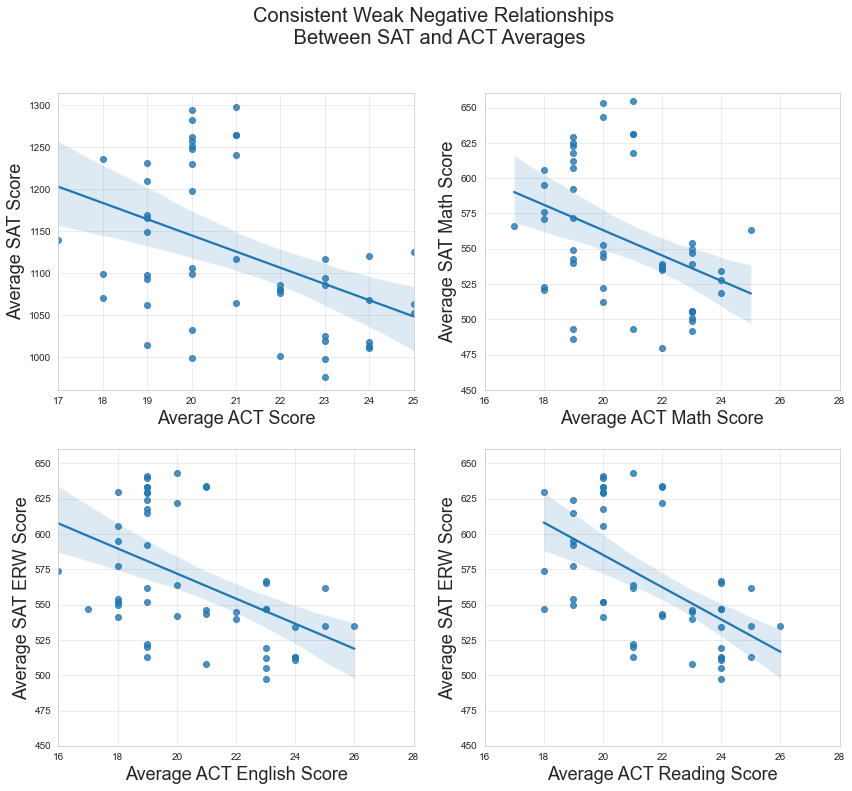

In [5]:
plt.figure(figsize = (14,12))

ax1 = plt.subplot(221)
sns.regplot(x='act_2018', y='sat_2018', data=test_scores)
plt.xlabel("Average ACT Score", fontsize = 18)
plt.ylabel("Average SAT Score", fontsize = 18)
plt.grid(True, linewidth=0.5, linestyle = '-', c='black', alpha = 0.15)


ax2 = plt.subplot(222)
sns.regplot(x='act_2018_math', y='sat_2018_math', data=test_scores)
plt.xlabel("Average ACT Math Score", fontsize = 18)
plt.ylabel("Average SAT Math Score", fontsize = 18)
plt.grid(True, linewidth=0.5, linestyle = '-', c='black', alpha = 0.15)
plt.xlim(16,28)
plt.ylim(450,660)


ax3 = plt.subplot(223, sharex=ax2, sharey=ax2)
sns.regplot(x='act_2018_english', y='sat_2018_erw', data=test_scores)
plt.xlabel("Average ACT English Score", fontsize = 18)
plt.ylabel("Average SAT ERW Score", fontsize = 18);
plt.grid(True, linewidth=0.5, linestyle = '-', c='black', alpha = 0.15)


ax4 = plt.subplot(224, sharex=ax2, sharey=ax2)
sns.regplot(x='act_2018_reading', y='sat_2018_erw', data=test_scores)
plt.xlabel("Average ACT Reading Score", fontsize = 18)
plt.ylabel("Average SAT ERW Score", fontsize = 18)
plt.grid(True, linewidth=0.5, linestyle = '-', c='black', alpha = 0.15)

plt.suptitle("Consistent Weak Negative Relationships \n Between SAT and ACT Averages", fontsize = 20)
;

## Participation Rates Drive Averages

We noted a negative correlation around -0.85 with participation and state average scores on both standardized college prep exams above. Below we produce a simple linear regression model and find over 70% of the variation between states' average SAT and ACT scores can be explained by state participation rates.

''

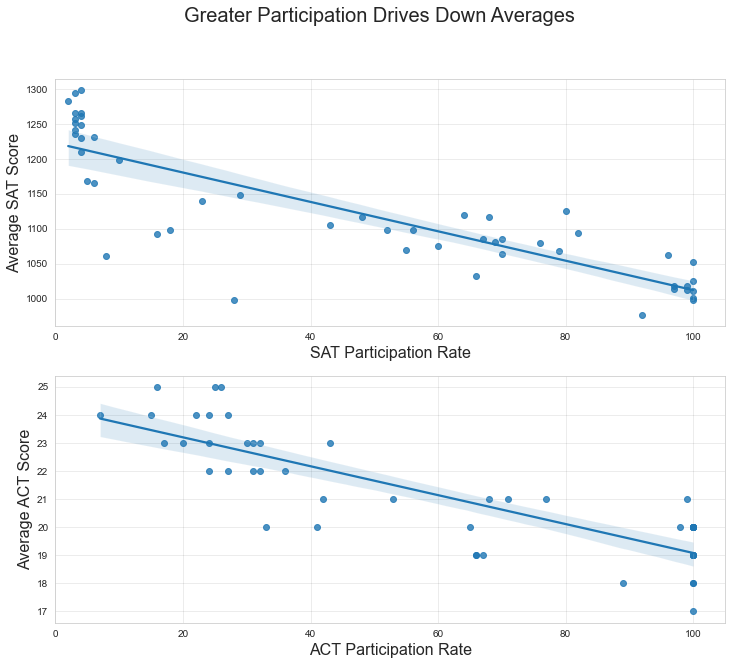

In [6]:
plt.figure(figsize = (12,10))

ax1 = plt.subplot(211)
sns.regplot(x='sat_2018_part', y='sat_2018', data=test_scores)

plt.xlabel("SAT Participation Rate", fontsize = 16)
plt.ylabel("Average SAT Score", fontsize = 16)
plt.grid(True, linewidth=0.5, linestyle = '-', c='black', alpha = 0.15)
plt.xlim(0,105)

ax2 = plt.subplot(212, sharex=ax1)
sns.regplot(x='act_2018_part', y='act_2018', data=test_scores)

plt.xlabel("ACT Participation Rate", fontsize = 16)
plt.ylabel("Average ACT Score", fontsize = 16)
plt.grid(True, linewidth=0.5, linestyle = '-', c='black', alpha = 0.15)

plt.suptitle("Greater Participation Drives Down Averages", fontsize = 20)
;

#### SLR with SAT

In [7]:
X = test_scores[['sat_2018_part']]
X = sm.add_constant(X)
y = test_scores['sat_2018']

lr_model = sm.OLS(y, X)
lr_sat_2018 = lr_model.fit()
print(lr_sat_2018.summary())

                            OLS Regression Results                            
Dep. Variable:               sat_2018   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.718
Method:                 Least Squares   F-statistic:                     128.0
Date:                Tue, 16 Jun 2020   Prob (F-statistic):           2.84e-15
Time:                        17:38:42   Log-Likelihood:                -270.74
No. Observations:                  51   AIC:                             545.5
Df Residuals:                      49   BIC:                             549.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1222.5831     11.121    109.938

In [8]:
print('Jarque-Bera (Normality) p-value: {}' \
      .format(round(sm.stats.jarque_bera(lr_sat_2018.resid)[1], 4)))
print('Breush-Pagan (Heteroskedasticity) p-value: {}' \
      .format(round(sm.stats.het_breuschpagan(lr_sat_2018.resid, lr_sat_2018.model.exog)[1],4)))
print('Harvey-Collier (Linearity) p-value: {}' \
      .format(sm.stats.linear_harvey_collier(lr_sat_2018)))

Jarque-Bera (Normality) p-value: 0.0
Breush-Pagan (Heteroskedasticity) p-value: 0.0465
Harvey-Collier (Linearity) p-value: Ttest_1sampResult(statistic=0.23446976852384427, pvalue=0.8156387512447113)


''

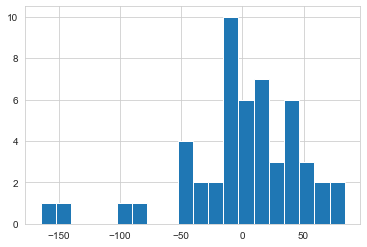

In [9]:
lr_sat_2018.resid.hist(bins=20)
;

Our diagnostics suggests some violation of OLS assumptions The large negative residuals derive from 4 states with low average SAT scores despite low participation rates, driving the low test p-values above. Because we are not interested in precisely estimatin gthe coefficient of participation rate and are merely describing the overall trend, we will ignore these tests because we can visually observe the strength of the relationship between participation and SAT averages in our above plot and the relative high R-squared value for a univariate model.

In [10]:
base_sat_mae = abs(y - y.mean()).mean()
slr_sat_mae = abs(lr_sat_2018.resid).mean()
print('SAT Mean Absolute Error Baseline: {}'.format(round(base_sat_mae,2)))
print('SAT Mean Absolute Error Participation SLR: {}'.format(round(slr_sat_mae,2)))

SAT Mean Absolute Error Baseline: 79.44
SAT Mean Absolute Error Participation SLR: 35.04


#### SLR with ACT

In [11]:
X = test_scores[['act_2018_part']]
X = sm.add_constant(X)
y = test_scores['act_2018']

lr_model = sm.OLS(y, X)
lr_act_2018 = lr_model.fit()
print(lr_act_2018.summary())

                            OLS Regression Results                            
Dep. Variable:               act_2018   R-squared:                       0.710
Model:                            OLS   Adj. R-squared:                  0.704
Method:                 Least Squares   F-statistic:                     119.9
Date:                Tue, 16 Jun 2020   Prob (F-statistic):           9.04e-15
Time:                        17:38:43   Log-Likelihood:                -77.710
No. Observations:                  51   AIC:                             159.4
Df Residuals:                      49   BIC:                             163.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            24.2326      0.330     73.346

In [12]:
print('Jarque-Bera (Normality) p-value: {}' \
      .format(round(sm.stats.jarque_bera(lr_act_2018.resid)[1], 4)))
print('Breush-Pagan (Heteroskedasticity) p-value: {}' \
      .format(round(sm.stats.het_breuschpagan(lr_act_2018.resid, lr_act_2018.model.exog)[1],4)))
print('Harvey-Collier (Linearity) p-value: {}' \
      .format(sm.stats.linear_harvey_collier(lr_act_2018)))

Jarque-Bera (Normality) p-value: 0.4664
Breush-Pagan (Heteroskedasticity) p-value: 0.6148
Harvey-Collier (Linearity) p-value: Ttest_1sampResult(statistic=2.1259570123440725, pvalue=0.03878941667817295)


''

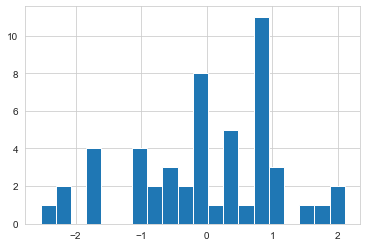

In [13]:
lr_act_2018.resid.hist(bins=20)
;

In contrast to ou SAT regression, the ACT model performs nicely with regard to OLS assumptions. We detect no significant departure from normality or homoskedasticity. We get a significant result for our linearity test because ACT scores display a weak curve-linear pattern. Because we are not interested in precisely modeling this relationship and only seeking to justify the claim that participation rates significantly impact state averages, our linear model is sufficient to prove the point. While the reciprocal relationship suggests a weaker effect near 100 percent participation, it strengthens the assertion that changes in participation drive changes in averages at mid to low participation rates.

In [14]:
base_act_mae = abs(y - y.mean()).mean()
slr_act_mae = abs(lr_act_2018.resid).mean()
print('ACT Mean Absolute Error Baseline: {}'.format(round(base_act_mae,2)))
print('ACT Mean Absolute Error Participation SLR: {}'.format(round(slr_act_mae,2)))

ACT Mean Absolute Error Baseline: 1.76
ACT Mean Absolute Error Participation SLR: 0.9


In [15]:
act_mae = abs(lr_act_2018.resid).mean()
print('ACT Mean Absolute Error {}'.format(round(act_mae,2)))

ACT Mean Absolute Error 0.9


#### Robustness Check: SAT

In [16]:
X = test_scores[['sat_2018_part']]
X = sm.add_constant(X)
y = test_scores['sat_2018_erw']

lr_model = sm.OLS(y, X)
lr_sat_2018_erw = lr_model.fit()
print(lr_sat_2018_erw.summary())

                            OLS Regression Results                            
Dep. Variable:           sat_2018_erw   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     149.3
Date:                Tue, 16 Jun 2020   Prob (F-statistic):           1.73e-16
Time:                        17:38:43   Log-Likelihood:                -230.71
No. Observations:                  51   AIC:                             465.4
Df Residuals:                      49   BIC:                             469.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           615.5268      5.073    121.343

In [17]:
X = test_scores[['sat_2018_part']]
X = sm.add_constant(X)
y = test_scores['sat_2018_math']

lr_model = sm.OLS(y, X)
lr_sat_2018_math = lr_model.fit()
print(lr_sat_2018_math.summary())

                            OLS Regression Results                            
Dep. Variable:          sat_2018_math   R-squared:                       0.685
Model:                            OLS   Adj. R-squared:                  0.679
Method:                 Least Squares   F-statistic:                     106.7
Date:                Tue, 16 Jun 2020   Prob (F-statistic):           6.80e-14
Time:                        17:38:43   Log-Likelihood:                -240.75
No. Observations:                  51   AIC:                             485.5
Df Residuals:                      49   BIC:                             489.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           606.8942      6.176     98.263

#### Robustness Check: ACT

In [18]:
X = test_scores[['act_2018_part']]
X = sm.add_constant(X)
y = test_scores['act_2018_math']

lr_model = sm.OLS(y, X)
lr_act_2018_math = lr_model.fit()
print(lr_act_2018_math.summary())

                            OLS Regression Results                            
Dep. Variable:          act_2018_math   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     136.8
Date:                Tue, 16 Jun 2020   Prob (F-statistic):           8.67e-16
Time:                        17:38:43   Log-Likelihood:                -74.633
No. Observations:                  51   AIC:                             153.3
Df Residuals:                      49   BIC:                             157.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            23.8575      0.311     76.701

In [19]:
X = test_scores[['act_2018_part']]
X = sm.add_constant(X)
y = test_scores['act_2018_science']

lr_model = sm.OLS(y, X)
lr_act_2018_science = lr_model.fit()
print(lr_act_2018_science.summary())

                            OLS Regression Results                            
Dep. Variable:       act_2018_science   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.690
Method:                 Least Squares   F-statistic:                     112.2
Date:                Tue, 16 Jun 2020   Prob (F-statistic):           2.87e-14
Time:                        17:38:43   Log-Likelihood:                -73.142
No. Observations:                  51   AIC:                             150.3
Df Residuals:                      49   BIC:                             154.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            23.7874      0.302     78.746

In [20]:
X = test_scores[['act_2018_part']]
X = sm.add_constant(X)
y = test_scores['act_2018_reading']

lr_model = sm.OLS(y, X)
lr_act_2018_reading = lr_model.fit()
print(lr_act_2018_reading.summary())

                            OLS Regression Results                            
Dep. Variable:       act_2018_reading   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                     182.8
Date:                Tue, 16 Jun 2020   Prob (F-statistic):           3.68e-18
Time:                        17:38:43   Log-Likelihood:                -72.492
No. Observations:                  51   AIC:                             149.0
Df Residuals:                      49   BIC:                             152.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            25.1063      0.298     84.177

In [21]:
X = test_scores[['act_2018_part']]
X = sm.add_constant(X)
y = test_scores['act_2018_english']

lr_model = sm.OLS(y, X)
lr_act_2018_english = lr_model.fit()
print(lr_act_2018_english.summary())

                            OLS Regression Results                            
Dep. Variable:       act_2018_english   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     108.2
Date:                Tue, 16 Jun 2020   Prob (F-statistic):           5.37e-14
Time:                        17:38:43   Log-Likelihood:                -87.201
No. Observations:                  51   AIC:                             178.4
Df Residuals:                      49   BIC:                             182.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            24.1602      0.398     60.709

#### Robustness Check: Summary

In [22]:
act_results = [lr_act_2018, lr_act_2018_math, lr_act_2018_science, lr_act_2018_reading, lr_act_2018_english]
act_coef = []
for res in act_results:
    act_coef.append(round(res.params[1],4))
    
sat_results = [lr_sat_2018, lr_sat_2018_math, lr_sat_2018_erw]
sat_coef = []
for res in sat_results:
    sat_coef.append(round(res.params[1],4))

In [23]:
print(sat_coef)
print(act_coef)

[-2.1, -1.0646, -1.0344]
[-0.0515, -0.0518, -0.0455, -0.0574, -0.0589]


Examining our coefficients for each subject test average, our results hold consistently. Because SAT score i the sum of the subject tests, we expect and observe a coefficient for subject tests around half of that for total SAT score. Because ACT composite score is the average of 4 subject tests, we expect and indeed observe similar coefficients compared to individual subjects. The closeness of these coefficients and relatively low standard errors in our OLS models suggest our conclusion regarding participation and state averages hold strongly.

## Changes in Participation Rates

Below, we create 4 tables illustrating the relationship between changes in state participation rates and state averages from 2017 to 2018. On both exams, we observe large changes in averages correlate with either extremely low participation rates and large-scale shifts in testing participation, likely driven by policy changes. Most states with dramatic changes in participation rates observe a dramatic shift in average scaores for that test.

In [24]:
# Generate year-over-year changes
test_changes = test_scores
test_changes['sat_score_change'] = test_changes['sat_2018'] - test_changes['sat_2017']
test_changes['act_score_change'] = test_changes['act_2018'] - test_changes['act_2017']
test_changes['sat_score_pchange'] = round(test_changes['sat_score_change'] / test_changes['sat_2017']*100, 2)
test_changes['act_score_pchange'] = round(test_changes['act_score_change'] / test_changes['act_2017']*100, 2)
test_changes['sat_part_change'] = test_changes['sat_2018_part'] - test_changes['sat_2017_part']
test_changes['act_part_change'] = test_changes['act_2018_part'] - test_changes['act_2017_part']
test_changes['sat_part_pchange'] = round(test_changes['sat_part_change'] / test_changes['sat_2017_part']*100, 2)
test_changes['act_part_pchange'] = round(test_changes['act_part_change'] / test_changes['act_2017_part']*100, 2)

test_changes = test_changes.loc[:,['sat_part_change', 'sat_score_change', 'sat_part_pchange', 'sat_score_pchange',
                                'act_part_change', 'act_score_change', 'act_part_pchange', 'act_score_pchange',]]

sat_change_cols = test_changes.columns[test_changes.columns.str.contains('sat')]
act_change_cols = test_changes.columns[test_changes.columns.str.contains('act')]

In [25]:
# Largest changes in SAT participation
test_changes.loc[:, sat_change_cols].sort_values('sat_part_change',ascending=False).head()

,sat_part_change,sat_score_change,sat_part_pchange,sat_score_pchange
State,,,,
Illinois,90,-96,1000.00,-8.61
Colorado,89,-176,809.09,-14.65
Rhode Island,26,-44,36.62,-4.14
Florida,14,-3,16.87,-0.29
West Virginia,14,-87,100.00,-8.01


In [26]:
# Largest changes in SAT average scores
test_changes.loc[:, sat_change_cols].sort_values('sat_score_change').head()

,sat_part_change,sat_score_change,sat_part_pchange,sat_score_pchange
State,,,,
Colorado,89,-176,809.09,-14.65
Illinois,90,-96,1000.00,-8.61
West Virginia,14,-87,100.00,-8.01
Ohio,6,-50,50.00,-4.35
New Mexico,5,-45,45.45,-3.95


In [27]:
# Largest changes in ACT participation
test_changes.loc[:, act_change_cols].sort_values('act_part_change').head()

,act_part_change,act_score_change,act_part_pchange,act_score_pchange
State,,,,
Colorado,-70,3,-70.00,15.00
Illinois,-50,2,-53.76,9.52
Alaska,-32,1,-49.23,5.26
Florida,-7,0,-9.59,0.00
Michigan,-7,0,-24.14,0.00


In [28]:
# Largest changes in ACT average scores
test_changes.loc[:, act_change_cols].sort_values('act_score_change',ascending=False).head()

,act_part_change,act_score_change,act_part_pchange,act_score_pchange
State,,,,
Colorado,-70,3,-70.00,15.00
Illinois,-50,2,-53.76,9.52
Washington,-5,1,-17.24,4.76
Vermont,-5,1,-17.24,4.35
Alaska,-32,1,-49.23,5.26


#### Plot Changes in Participation and Average Scores

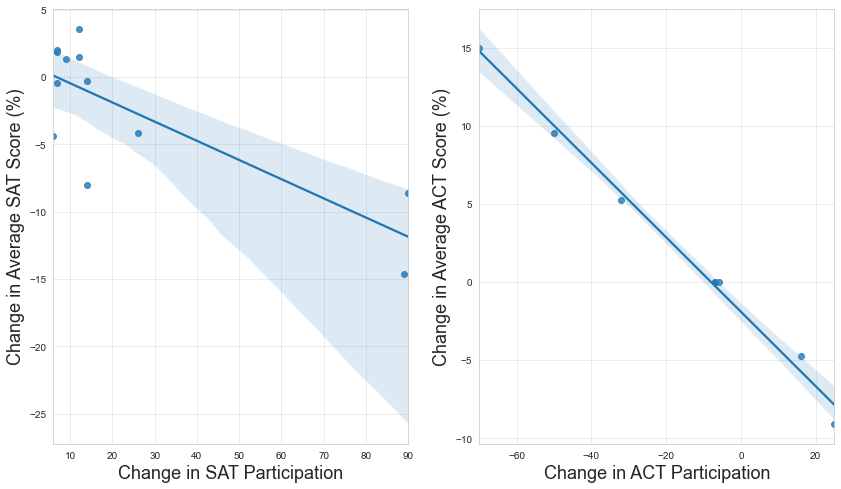

In [29]:
plt.figure(figsize = (14,8))

ax1 = plt.subplot(121)
sns.regplot(x='sat_part_change', y='sat_score_pchange', 
            data=test_changes.loc[(abs(test_changes['sat_part_change']) > 5), :])
plt.xlabel("Change in SAT Participation", fontsize = 18)
plt.ylabel("Change in Average SAT Score (%)", fontsize = 18)
plt.grid(True, linewidth=0.5, linestyle = '-', c='black', alpha = 0.15)


ax2 = plt.subplot(122)
sns.regplot(x='act_part_change', y='act_score_pchange', 
            data=test_changes.loc[(abs(test_changes['act_part_change']) > 5),:])
plt.xlabel("Change in ACT Participation", fontsize = 18)
plt.ylabel("Change in Average ACT Score (%)", fontsize = 18)
plt.grid(True, linewidth=0.5, linestyle = '-', c='black', alpha = 0.15)

While changes in SAT paticipation tended to be clustered beteen 20 percentage points, changes in ACT participation were more spread. We observe a clear linear pattern between changes in ACT participation and percent change in state average ACT scores. The two outlier states with dramatic increases in SAT participation experienced substantial declines in state averages while states with moderate changes in participation ahd mixed results.

## Case Studies

#### Colorado
We observed in our available data a 90% spike in SAT participation between the 2017 and 2018 graduating classes. As expected, Diane Rado of the Chicago Tribune reported in 2016 that in 2015 a new law from the Illinois legislature went into effect requiring all students to take a college entrance exam as part of the state's mandated testing schedule [here](https://www.chicagotribune.com/news/ct-illinois-chooses-sat-met-20160211-story.html). SAT won a contract to provide that service and thus gained a sizeable new market.

#### Illinois
As in Illinois, Colorado experienced an 89% spike in SAT participation. Monte Whaley of the Denver Post reported in 2017 that Colorado was transitioning to the new SAT in place of the ACT [here](https://www.denverpost.com/2017/03/06/colorado-juniors-sat-college-exam/). In his reporting, Mr. Whaley explains the newly redesigned SAT seemed a more representative test of student knowledge to policy-makers and fit into a larger strategy of reducing the quantity of standardized tests.

#### Rhode Island
While much smaller in magnite, Rhode Island experienced a sizeable increase in SAT participation at 26%. As reported by Linda Bord at the Providence Journal in 2018, Rhode Island implemented a new requirement that all students take the SAT to graduate [here](https://www.providencejournal.com/news/20181025/with-sat-required-ri-sees-jump-in-participation-decline-in-scores). While the College Board did not gain an entirely new market in this case, it certainly strengthened its identity as the standardized college admissions test for that state.

In [30]:
# Largest changes in SAT participation
test_changes.sort_values('sat_part_change',ascending=False).head(3)

,sat_part_change,sat_score_change,sat_part_pchange,sat_score_pchange,act_part_change,act_score_change,act_part_pchange,act_score_pchange
State,,,,,,,,
Illinois,90,-96,1000.00,-8.61,-50,2,-53.76,9.52
Colorado,89,-176,809.09,-14.65,-70,3,-70.00,15.00
Rhode Island,26,-44,36.62,-4.14,-6,0,-28.57,0.00


#### Analysis

Having identified the only 3 states with a change of over 25 percentage points in either test and identified a government policy change driving these dramatic changes, we now explore the impact on state averages. 

With Illinois SAT participation rate increasing by 90 percentage points, the SAT average decreased by 96 points or 8.6 percent. Conversely, the 50 percentage point drop in ACT participation is associated with a 2.5 increase in average ACT score or 11.7 percent. Similarly for Colorado, the 89 percentage point increase in SAT participation is associated with a 176 point drop in average SAT score or 14.7 percent. The 70 percentage point drop in ACT participation is associated corresponds with a 3.1 point increase in ACT averages or 14.9 percent. These two states with the most dramatic changes in participation rates also experienced the greatest changes in average SAT scores in both absolute and relative terms compared to other states.

Rhode Island experienced similar trends with a 44 point or 4.1 percent drop in SAT average score. While not as dramatic as Colorado or Illinois, its of a similar scale for being only half as large a change in participation rate as these other states. It appears fifth or sixth in overall change rankings only because states such as West Virginia or Ohio had a much larger relative change due to their extremely low participation rates in 2017.

## Conclusion

This notebook demonstrates the fundamental flaw in treating state averages as representative of state systems at large when the participants are not randomly selected. The SAT and ACT are just one context where non-random, self-selecting populations generate outcomes that get reported as objective measures to compare states in news media. While unable to claim causality, the ability of a single variable regression model to consistently generate an R-squared over 70 and the case-studies of Colorado, Illinois, and Rhode Island provide strong evidence that state averages on standardized test primarily reflect the testing policies of those states and their subsequent participation rates, rather than any meaningful difference in quality of education.